## Nature Language Process(NLP)

统计语言模型的核心思想就是判断一个文字序列是否能构成人类能够理解并且有意义的句子。

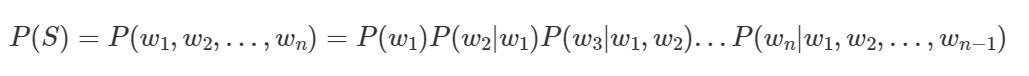

而预测序列的下一个单词即第N个单词，也就变成了他前面N-1个词语的条件概率。

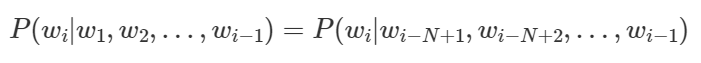

这种假设被称为马尔科夫假设，对应的语言模型也被称为N-Gram，常见的2-Gram、3-Gram，任意词语的出现只和他前面的1个、2个单词有关。

而在此基础上衍生的模型为了捕获之前更长的序列，产生了RNN、LSTM、Transformer等模型。


### Transformer模型

Transformer模型主要分为三类：
- Encoder-only模型（例如Bert）: 自编码模型
- Decoder-only模型（例如GPT）:  自回归模型
- Encoder-Decoder模型（例如BART、T5）: seq2seq模型

#### Transformer的架构

Transformer的标志是使用了注意力层(Attention Layers)的结构，注意力层的作用是让模型在处理文本时，将注意力只放在某些词语上。

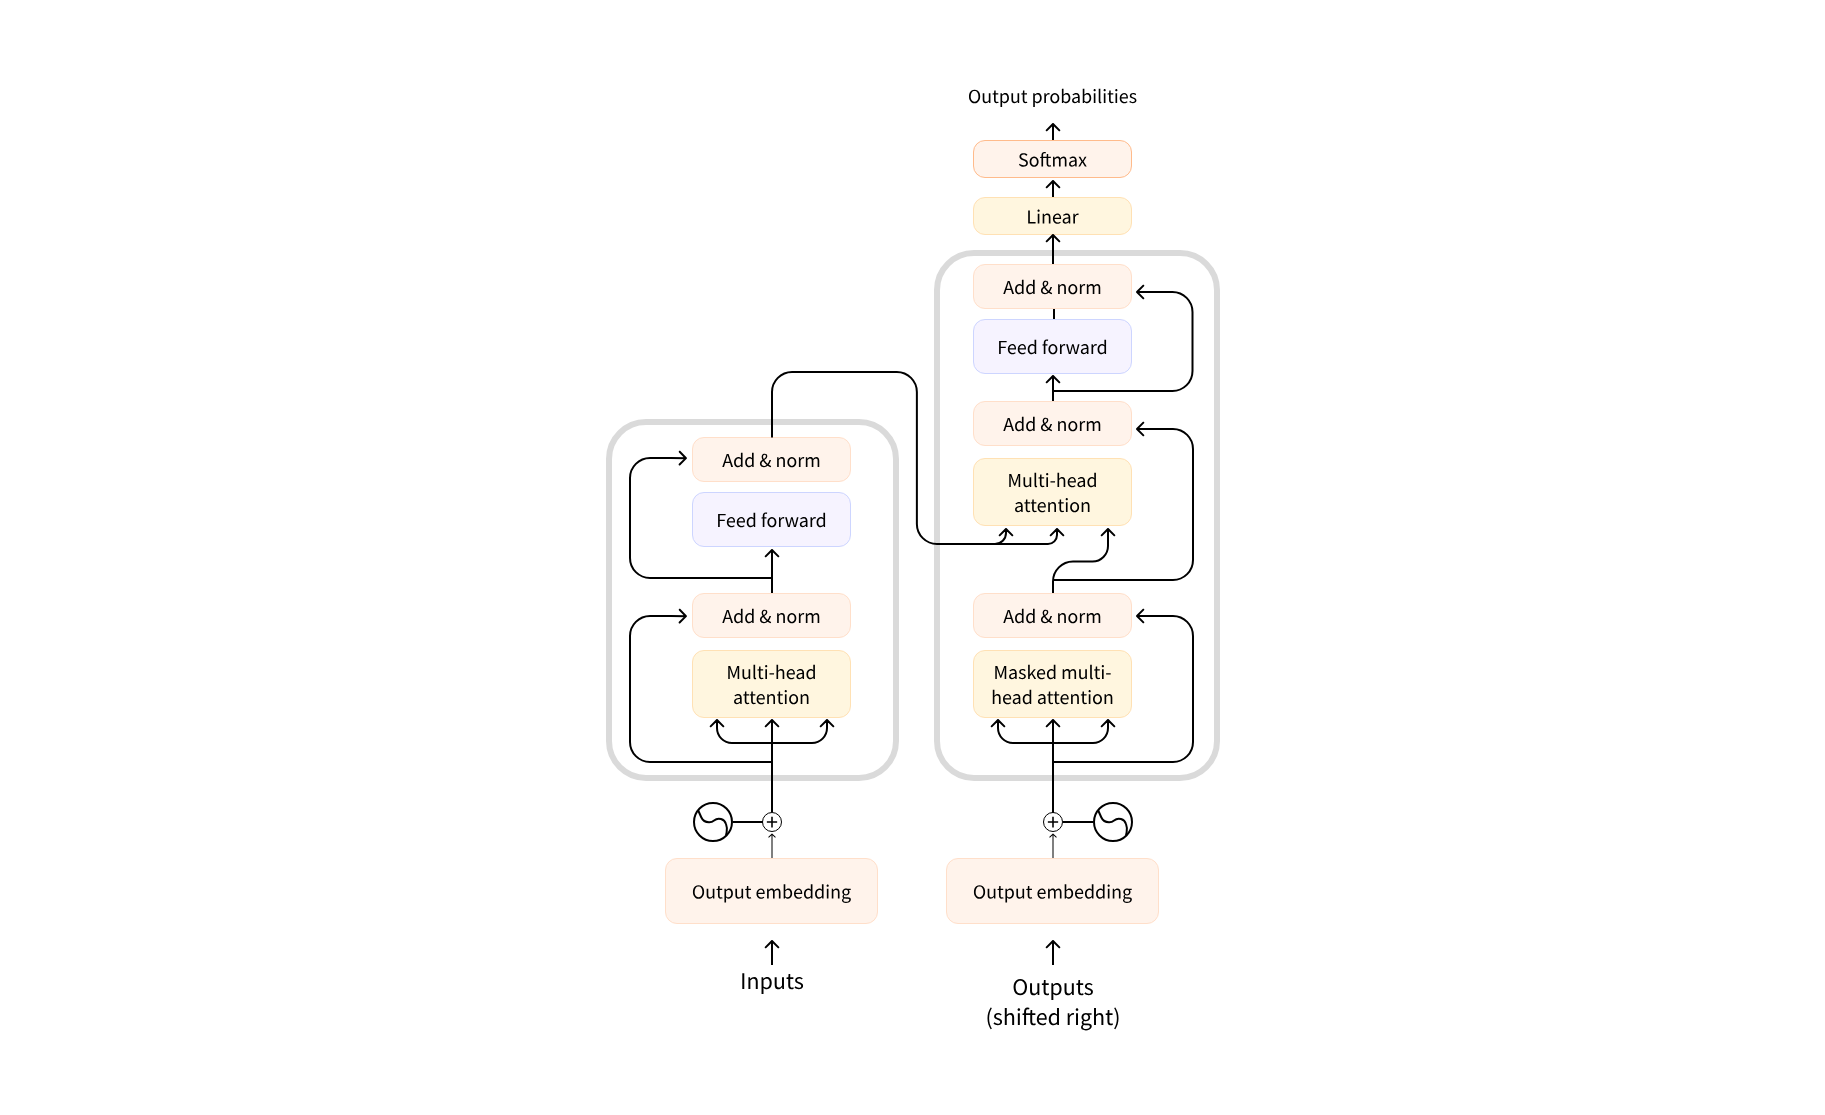

Transformer模型家族大致可以分为如下几类

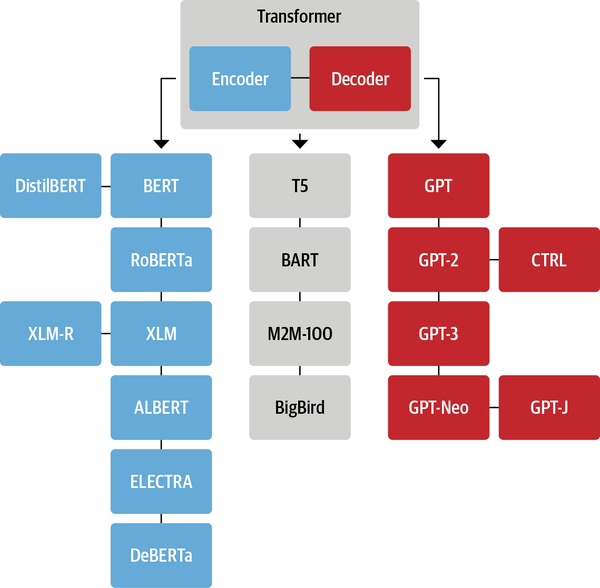

##### 注意力机制(Scaled Dot-product Attention)

Attention机制作用于整个文本，相比RNN逐步获得全局信息，而CNN只能获得局部信息，一步到位获得了全局信息。

核心机制Scaled Dot-product Attention

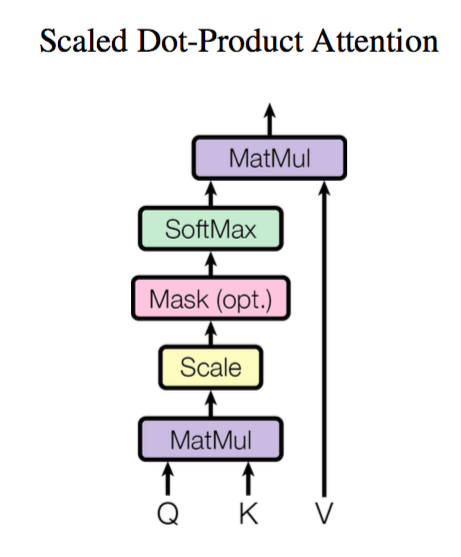

Scaled Dot-product Attention 主要包含两个步骤：
1. 计算注意力的权重：使用某种相似度函数度量每一个query向量和所有key向量之间的关联程度，对于长度为m的query序列和一个长度为n的Key序列，会生成一个mxn的注意力分组矩阵。由于点积灰产生一个大的数字，这个时候需要乘以一个缩放银子来标准化方差，然后使用softmax标准化。最终得到的结果是query和key之间的关联程度矩阵$w_{ij}$。
2. 更新token embeddings：将权重矩阵$w_{ij}$ 和对应的value向量相乘得到更新后的语义。

计算公式为: $Attention(Q, K, V) = softmax(\frac {QK^T} {\sqrt {d_k}}) V$

其中  $Q ∈ R^{m \times d_k}, K ∈ R^{n \times d_k}, V ∈ R^{n \times d_v} $ 最终得到$m \times d_v$的矩阵。

```python

import torch
import torch.nn.functional as F
from math import sqrt

def scaled_dot_product_attention(query, key, value, query_mask=None, key_mask=None, mask=None):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / sqrt(dim_k)
    if query_mask is not None and key_mask is not None:
        mask = torch.bmm(query_mask.unsqueeze(-1), key_mask.unsqueeze(1))
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -float("inf"))
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)
```


##### 多头机制 (Multi-Head Attention)

Multi-Head Attention 线性映射将Q、K、V序列映射到特征空间，每一组投影后的向量成为一个头。然后在魅族映射后的序列上在进行Scaled Dot-product Attention。

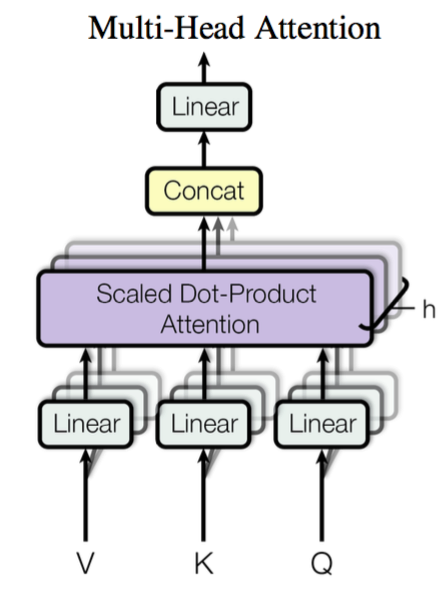

$$
\begin{align}
head_i &= Attention(QW_i^Q, KW_i^K, VW_i^V) \\
MultiHead(Q, K, V) &= Concat(head_1, ..., head_h)

\end{align}
$$

其中h为注意力头的数量， 一般都将 head_dim设置为embed_dim的因数，而embed_dim 也基本上是hidden_size，head_dim = embed_dim / num_heads
```python

from torch import nn

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)

    def forward(self, query, key, value, query_mask=None, key_mask=None, mask=None):
        attn_outputs = scaled_dot_product_attention(
            self.q(query), self.k(key), self.v(value), query_mask, key_mask, mask)
        return attn_outputs

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, query_mask=None, key_mask=None, mask=None):
        x = torch.cat([
            h(query, key, value, query_mask, key_mask, mask) for h in self.heads
        ], dim=-1)
        x = self.output_linear(x)
        return x

```


##### Positional Embeddings

由于注意力机制无法捕捉词语之间的位置信息，因此Transformer模型还使用了Postional Embeddings添加了词语的位置信息，核心思想：使用位置相关的值来增强词向量。

存在替代方案：
- 绝对位置表示： 使用调制的正弦和余弦信号组成的静态模式编码位置，比如rotary emebeddings
- 相对位置表示


##### FlashAttention

来源[FlashAttention:加速计算,节省显存, IO感知的精确注意力](https://zhuanlan.zhihu.com/p/639228219)

transformer模型的计算复杂度和空间复杂度都是$O(N^2)$, 其中N为序列长度。

transformer模型计算量 $l * (24bNh^2 + 4bN^2h)$, 中间激活显存为 $l * (34bNh + 5bN^2a)$, a为注意力多头数。
因此transformer模型的计算随序列长度呈2次方增长。其中的$N^2$项均是self-attention块产生的。

大模型GPT4将序列长度扩展到32K，Calude扩展到100K，会极大的影响到性能。

因此flash attention的出现是为了加速计算，节省内存。Transformer中大部分计算操作的瓶颈是显存访问。

Flash Attention的优点。

1. 加快了计算（Fast）。Flash Attention并没有减少计算量FLOPs，而是从IO感知出发，减少了HBM访问次数，从而减少了计算时间。论文中用到了"wall-clock time"这个词，时钟时间不仅包含了GPU运行耗时，还包含了IO读写的阻塞时间。减少HBM访问次数，是通过tiling技术分块和算子融合来实现的。

2. 节省了显存（Memory-efficient）。Flash Attention通过引入统计量，改变注意力机制的计算顺序，避免了实例化注意力矩阵，将显存复杂度从$O(N^2)$降低到了$O(N)$。这个技巧不是首创的，在[4][5]中也有应用。

3. 精确注意力（Exact Attention）。不同于稀疏注意力，Flash Attention只是分块计算，而不是近似计算，Flash Attention与原生注意力的结果是完全等价的。

###### 内存受限和计算受限

计算带宽（math bandwidth）指的是处理器每秒钟可以执行的数学计算次数，单位通常是OPS(即operations/second)。如果用浮点数进行计算，单位是FLOPS。例如，A100-40GB SXM的计算带宽为312TFLOPS。

内存带宽 （memory bandwidth）指的是处理器每秒钟从内存中读取的数据量，单位是bytes/second。例如，A100-40GB SXM的内存带宽为1555GB/s。

从数学上分析，浮点数计算次数为$N_op$，内存访问量为 $N_byte$，计算带宽为$BW_math$，内存带宽为 $BW_mem$。

访问内存花费的时间为 $T_mem$，计算花费的时间为 $T_math$。由于可以“边计算上一个，边读/写下一个”，访问内存和计算的时间可以重叠，此时总的运行时间为 $max(T_mem, T_math)$。

当$T_mem > T_math$ 就是访存受限

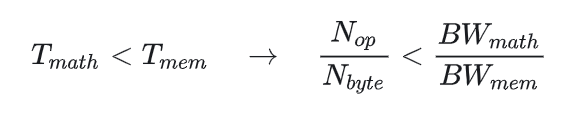


当$T_mem < T_math$ 就是计算受限

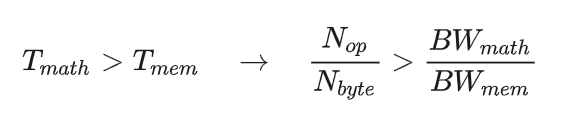

ops/bytes = $\frac {N_op} {N_byte}$定义为计算强度。

在GPU中HBM速度为1.5TB/s，而SRAM为19TB，所以减少对HBM的读取，而使用速度更快的SRAM能够显著的减少内存瓶颈，提升速度。

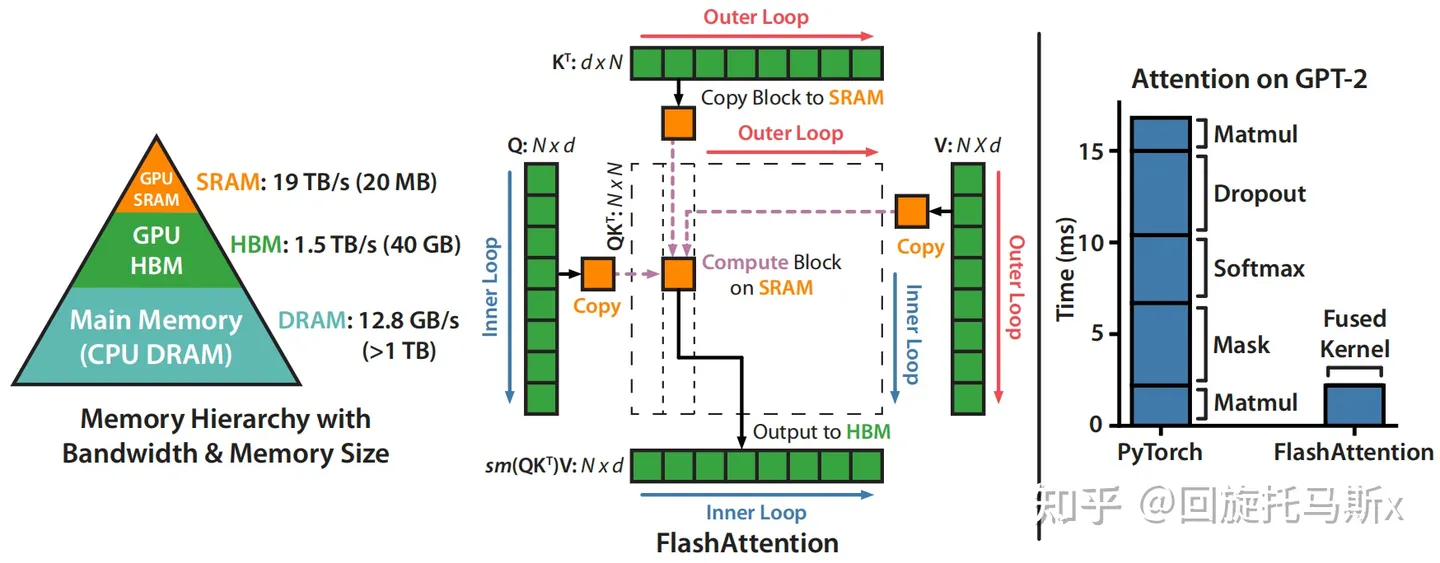

下图为self-attention 的标准实现，其中存在多次反复读写HBM的操作，而这些操作也都是内存受限。

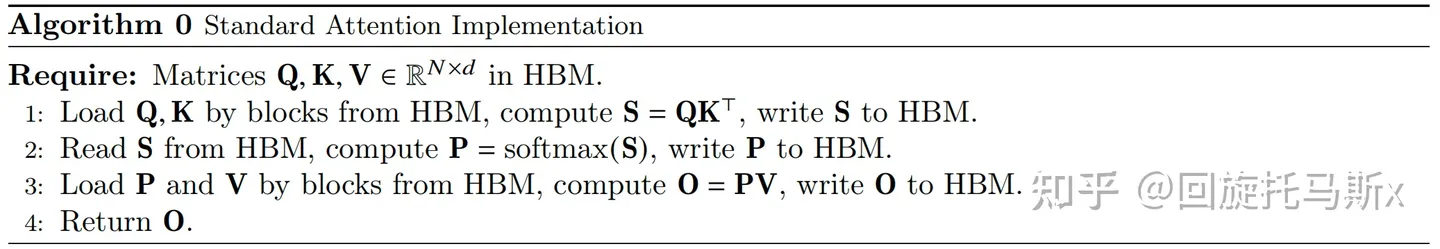

所以flash attention的优化则是将融合了这些op，从而优化了多次读写，以及多次读写中占用的显存。

##### PagedAttention

论文见 [Efficient Memory Management for Large Language Model Serving with PagedAttention](https://arxiv.org/abs/2309.06180)

将操作系统中的虚拟内存中的分页经典分页思想引入到的LLM服务中，而无需任何模型架构修改的情况下，达到比Transformers更高的的Throughput。

问题：KV Cache的大小取决于序列的长度，是不可预测的，因此对于管理KV cache的挑战较大。由于内存碎片化和内存过度保留，系统浪费了60%-80%的显存。

为了解决这个问题，研究引入了PagedAttention， 允许在非连续的内存空间连续存储key和value。

![img](https://pic3.zhimg.com/v2-e8a2317d1bc7ba5670ca05f68196453e_b.webp)

序列的连续逻辑块通过块表映射到非连续物理块中。物理块在生成新 token 时按需分配。

![img](https://pic2.zhimg.com/v2-6035b0440dd9f0eb37bc9c221b977799_b.webp)

在 PagedAttention 中，内存浪费只会发生在序列的最后一个块中。
这使得在实践中可以实现接近最佳的内存使用，仅浪费不到 4%。这种内存效率的提升被证明非常有用，允许系统将更多序列进行批处理，提高 GPU 使用率，显著提升吞吐量。




##### softmax tiling

参考文章

[【手撕LLM-Flash Attention】从softmax说起，保姆级超长文！！](https://zhuanlan.zhihu.com/p/663932651)

[【手撕LLM-FlashAttention2】只因For循环优化的太美](https://zhuanlan.zhihu.com/p/670085985)

在融合self-attention 最大的问题在于softmax 的计算，正常计算softmax需要获取到softmax 归约的整个维度信息，

而为了利用tensorcore 和sram加速融合实现，则必然需要对输入的矩阵进行分块，分块之后softmax的规约则是最大的问题。




#### Transformer模型参数量和计算量

分析decoder-only transformer， 模型的参数量、计算量、中间激活值、KV cache

参考文章 [分析transformer模型的参数量、计算量、中间激活、KV cache](https://zhuanlan.zhihu.com/p/624740065)

##### 模型参数量

transformer模型整体有 embedding + n * decoder layer + lm head构成。decoder layer 由self attention和mlp 构成。

self attention 主要由 q_proj、k_proj、v_proj、o_proj 构成，权重为$W_q$、$W_k$、$W_v$、$W_o$以及对应的偏置，
四个权重矩阵的形状都是[h, h]，4个偏置为[h]，所以整体的参数量为 $4h^2 + 4h$。

mlp层主要由2个线性层组成，一般第一个线性层将维度从h 映射到 4h，第二个线性层将维度从4h映射到h维度上，
所以第一个线性层的形状[h, 4h]，偏置形状为[4h]，第二个线性层[4h, h]，偏置为[h]，所以mlp层的参数量为$8h^2 + 5h$。

然后decoder layer中一般还有两个layernorm，layernorm 包含了参数$\gamma$ 和 $\beta$， 形状都是[h]，所以最后的参数量为4h。

每层transformer layer的总参数量为$12h^2 + 13h$。

embedding 层主要为vocab的数量 x hidden，所以参数量为Vh，lm head 和embedding 是参数共享的所以不重复计算了。


##### 训练过程中的显存占用

训练过程中，占用显存的4部分为：模型参数、前向计算产生的中间激活、后向传递计算得到的梯度、优化器状态。

训练大模型的时候通常会使用混合精度计算，以及AdamW优化器。

在一次训练迭代中，每个可训练参数都会对一个1个梯度，并对应2个优化器状态。

假设模型参数量为$\Phi$, 梯度数量为$\Phi$，AdamW优化器元素数量为$2\Phi$。

在使用混合精度训练过程中，会使用fp16进行前向和反向传递，计算得到fp16的梯度；优化器更新参数时，使用float32优化器状态，float32的梯度、float32的模型参数更新模型。

因此占用了(2 + 4) + (2 + 4) + (4 + 4) = 20bytes对应每个参数，则总体占用显存为$20 \Phi$。

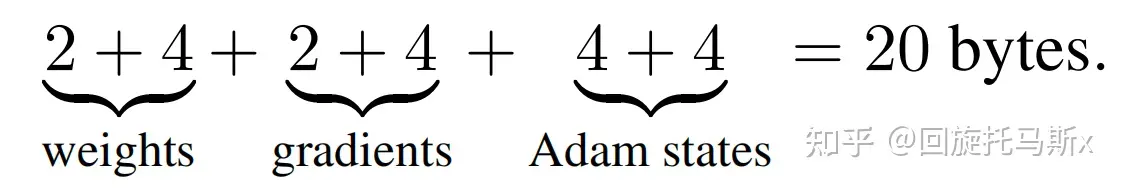

##### 推理过程中的显存占用


##### 计算Flops

> A @ B 矩阵乘法，A 的shape为(m, k), B的shape为(k, n), 计算矩阵中每一个元素点需要进行k次乘法和k次加法，则最终输出(m, n)的矩阵计算量为 2kmn，如果加上bias 则为 2kmn + mn

假设输入数据的shape 为(b, s), 则产生的hidden states shape 为(b, s, h)

$ self_attention(Q, K, V) = softmax(\frac {QK^T} {\sqrt {d_k}}) \cdot V \cdot W_o$

self attention中单个gemm 进行运算为 (b, s, h) @ (h, h) + (h)

1. Q、K、V矩阵的计算量为 $6bsh^2$
2. $QK^T$ 的输入输出shape为(b, head_num, seq_len, head_dim) @ (b, head_num, head_dim, seq_len) = (b, head_num, seq_len, seq_len), 则计算量为2b * head_num * head_dim * seq_len * seq_len = $2bs^2h$
3. 计算 $score \cdot V$, (b, head_num, seq_len, seq_len) @ (b, head_num, seq_len, head_dim) = (b, head_num, seq_len, head_dim)，则计算量为 2b * head_num * seq_len * seq_len * head_dim = $2bs^2h$
4. 计算o_proj, (b, s, h) @ (h, h) = (b, s, h), 计算量$2bsh^2$

mlp 中主要为2个线性层的计算
1. 第一个线性层，(b, s, h) @ (b, h, 4h) = (b, s, 4h)，计算量为$8bsh^2$
2. 第二个线性层，(b, s, 4h) @ (b, 4h, h) = (b, s, h)，计算量为$8bsh^2$

则transformer 整层的计算量为 $24bsh^2 + 4bs^2h$

然后是logits的计算量为(b, s, h) @ (h, V) = (b, s, V)，计算量为$2bshV$

##### kv cache

在推断阶段，transformer模型加速推断的一个常用策略就是使用 KV cache。一个典型的大模型生成式推断包含了两个阶段：

1. 预填充阶段：输入一个prompt序列，为每个transformer层生成 key cache和value cache（KV cache）。

2. 解码阶段：使用并更新KV cache，一个接一个地生成词，当前生成的词依赖于之前已经生成的词。

缓存已经推理出来n-1 step时候的key_states和value_state(统称为kv cache)。在进行推理n step的时候，将当前层推得的key_states 和value_states  和kv cache中的结果concat。

transformer 模型进行生成的时候，开启了use_cache的情况下，只有首次输入是全tokens，在后续的不断生成递归过程中是1 token输入的。如果关闭了use_cache的情况下，每次输入的都是全token，即 n-1 step中 输入m tokens + 推理出来的 1 token，得到的m + 1 个tokens 送入第n次step中。

所以kv cache 就是利用空间换时间，缓存下每次计算下来的key_states和value_states，避免了重复计算。

### 相关论文

[Attention is All Your Need](https://arxiv.org/abs/1706.03762)

[FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness](https://arxiv.org/pdf/2205.14135.pdf)




In [28]:
'''
this is code for softmax tiling implementaion
'''

import numpy as np

np.random.seed(42)

data = np.random.randn(10, 2048)
n_partition = 128

def compute(input: np.ndarray, cur_max: np.ndarray):
    exp_value = np.exp(input - cur_max)
    exp_sum = np.sum(exp_value, axis=-1, keepdims=True)
    return exp_value, exp_sum

def softmax(input: np.ndarray, n_partition):
    assert input.shape[1] % n_partition == 0
    num_per_partition = input.shape[1] // n_partition
    g_max_values = np.full((input.shape[0], 1), -np.inf)
    cur_maxes = []
    exp_values = []
    exp_sums = []
    for i in range(n_partition):
        partition_input = input[:, num_per_partition * i : num_per_partition * (i + 1)]
        max_values = np.max(partition_input, axis=-1, keepdims=True)
        exp_value, exp_sum = compute(partition_input, max_values)
        g_max_values = np.maximum(g_max_values, max_values)
        cur_maxes.append(max_values)
        exp_values.append(exp_value)
        exp_sums.append(exp_sum)
    for i in range(n_partition):
        cur_max = cur_maxes[i]
        exp_value = exp_values[i]
        exp_sum = exp_sums[i]
        # print(cur_max.shape, g_max_values.shape)
        diff = np.exp(cur_max - g_max_values)
        exp_values[i] *= diff
        exp_sums[i] *= diff
        # print(exp_sums[i].shape, exp_values[i].shape)
    exp_values = np.concatenate(exp_values, axis=-1)
    exp_sums = np.sum(np.concatenate(exp_sums, axis=-1), axis=-1, keepdims=True)
    result = exp_values / exp_sums
    return result


def softmax_np(x):
    x -= np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

result = softmax(data, n_partition)

expect = softmax_np(data)

np.allclose(result, expect, atol=1e-3, rtol=1e-3)

True